<font color="#CA3532"><h2 align="left">Impacto del Análisis de Sentimientos en la Predicción de Precios Financieros</h2></font> 
<font color="#CA3532"><h2 align="left">Comparativa entre LSTM, BERT y FinBERT</h2></font>

## Índice

#### [Apartado 1: Librerias y Configuración Inicial](#apartado-1)

#### [Apartado 2: Obtención de Datos Financieros y de Noticias](#apartado-2)

#### [Apartado 3: Preprocesamiento y Limpieza de Datos](#apartado-3)

#### [Apartado 4: Análisis de Sentimientos](#apartado-4)

#### [Apartado 5: Complementos](#apartado-5)

#### [Apartado 6: Entrenamientos](#apartado-6)

#### [Apartado 7: Evaluación y Visualización de Resultados](#apartado-7)

#### [Apartado 8: Resultados](#apartado-8)

<a id="apartado-1"></a>
### Apartado 1: Librerias y Configuración Inicial

In [1]:
# Declaración de librerías generales
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtención de datos
import time
import yfinance as yf
import requests
import logging
from datetime import datetime, timedelta

# Limpieza y procesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')

# Preprocesamiento y métricas
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

logging.basicConfig(level=logging.INFO)

# Parámetros generales
API_KEY = 'FINNHUB API KEY'
SYMBOL = 'AAPL'
START_DATE = '2024-03-31'
END_DATE = '2025-03-25'
LOOK_BACK = 5

<a id="apartado-2"></a>
### Apartado 2: Obtención de Datos Financieros y de Noticias

In [2]:
# Función para obtener precios históricos
def historical_data(symbol, start_date, end_date):
    # Inicio de la búsqueda de datos
    logging.info(f"Buscando precios de {symbol} desde {start_date} hasta {end_date}...")
    try:
        # Descarga los datos de Yahoo Finance
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        stock_data.reset_index(inplace=True)
    except Exception as e:
        logging.error(f"Error al descargar datos para {symbol}: {e}")
        return pd.DataFrame()
    # Asegura que la columna Date sea solo fecha
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    # Se filtran las columnas de interés
    stock_data = stock_data[['Date','Open','High','Low','Close','Volume']]
     # Calcula y añade el indicador NSI
    stock_data['NSI'] = nsi(stock_data)
    # Nomenclatura y formato del archivo de salida
    filename = f"{symbol}_historical_data.csv"
    try:
        logging.info(f"Guardando {filename}...")
        stock_data.to_csv(filename, index=False)
    except Exception as e:
        logging.error(f"Error al guardar {filename}: {e}")
    
    return stock_data

# Función para obtener noticias financieras
def news_data(symbol, start_date, end_date, api_key):
    # Se cargan fechas y contador de llamadas
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt   = datetime.strptime(end_date,   "%Y-%m-%d")
    all_news, call_count = [], 0
    # Palabras clave para filtrar noticias
    apple_keywords = ['Apple','iPhone','Mac','iPad','Tim Cook','iOS','macOS','Apple Watch','AirPods']
    # Se itera día a día en el rango solicitado
    while current_date <= end_date_dt:
        date_str = current_date.strftime("%Y-%m-%d")
        logging.info(f"Buscando noticias para {symbol} en {date_str}...")
        url    = 'https://finnhub.io/api/v1/company-news'
        params = {'symbol': symbol, 'from': date_str, 'to': date_str, 'token': api_key}
        try:
            resp = requests.get(url, params=params); resp.raise_for_status()
            for item in resp.json():
                hl = item.get('headline','')
                if any(k.lower() in hl.lower() for k in apple_keywords):
                    all_news.append({
                        'datetime': datetime.fromtimestamp(item['datetime']).date(),
                        'headline': hl})
        except Exception as e:
            logging.error(f"Error buscando noticias para {symbol} en {date_str}: {e}")
        # Gestión de límite de llamadas por minuto
        call_count += 1
        if call_count >= 55:
            logging.info("Límite de llamadas alcanzado; esperando 60s...")
            time.sleep(60); call_count = 0
        current_date += timedelta(days=1)
    # Nomenclatura y formato del archivo de salida
    news_df = pd.DataFrame(all_news)
    filename = f"{symbol}_news_data.csv"
    try:
        logging.info(f"Guardando {filename}...")
        news_df.to_csv(filename, index=False)
    except Exception as e:
        logging.error(f"Error al guardar {filename}: {e}")

    return news_df

<a id="apartado-3"></a>
### Apartado 3: Preprocesamiento y Limpieza de Datos

In [3]:
# Función para limpieza y procesamiento de texto
def process_text(text):
    if not isinstance(text, str):
        return ""
    
    # Eliminar URLs y etiquetas HTML
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # Eliminar espacios extra y recortar
    text = re.sub(r'\s+', ' ', text).strip()
    # Convertir a minúsculas
    text = text.lower()
    # Filtrar caracteres: se permiten letras, números, espacios y algunos caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s%$#@]', '', text)
    # Tokenización
    words = text.split()
    # Eliminar stopwords, conservando "not" y "never"
    stop_words = set(stopwords.words('english')) - {'not', 'never'}
    words = [word for word in words if word not in stop_words]
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

    

<a id="apartado-4"></a>
### Apartado 4: Análisis de Sentimientos

In [4]:
# Función auxiliar para cálculo de sentimiento
def sentiment_score(result):
    if isinstance(result, list):
        result = result[0]
    label = result.get('label', '').upper()
    score = result.get('score', 0)
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -score
    else:
        return 0

# Análisis de sentimientos con BERT
def analyze_sentiment_bert(news_df):
    logging.info("Analizando sentimientos con BERT...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    
    # Preprocesamiento de solo titulares
    news_df['cleaned_headline'] = news_df['headline'].apply(process_text)

    # Analizar titulares
    headlines = news_df['cleaned_headline'].tolist()
    headlines_results = sentiment_analyzer(headlines, truncation=True)
    news_df['headline_sentiment'] = [sentiment_score(res) for res in headlines_results]

    daily_sentiments = news_df.groupby('datetime')['headline_sentiment'].mean().reset_index()
    logging.info("Análisis de sentimientos con BERT completado.")
    return daily_sentiments

# Análisis de sentimientos con FinBERT
def analyze_sentiment_finbert(news_df):
    logging.info("Analizando sentimientos con FinBERT...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="ProsusAI/finbert")
    
    # Preprocesamiento de solo titulares
    news_df['cleaned_headline'] = news_df['headline'].apply(process_text)

    # Analizar titulares
    headlines = news_df['cleaned_headline'].tolist()
    headlines_results = sentiment_analyzer(headlines, truncation=True)
    news_df['headline_sentiment_finbert'] = [sentiment_score(res) for res in headlines_results]

    daily_sentiments_finbert = news_df.groupby('datetime')['headline_sentiment_finbert'].mean().reset_index()
    logging.info("Análisis de sentimientos con FinBERT completado.")
    return daily_sentiments_finbert

<a id="apartado-5"></a>
### Apartado 5: Complementos

In [5]:
# Definición de la capa de atención personalizada
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Peso de proyección de características a un score de atención
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        # Bias para cada timestep
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Función para calcular NSI (Numerical Sentiment Index)
def nsi(data: pd.DataFrame, s: float = 0.01, k: int = 1) -> pd.Series:
    ret = (data['Close'].shift(-k) - data['Open']) / data['Open']
    nsi = np.where(ret > s, 1, np.where(ret < -s, -1, 0))
    return pd.Series(nsi.ravel(), index=ret.index)

# Funciones de ayuda para series de tiempo
def lstm_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


<a id="apartado-6"></a>
### Apartado 6: Entrenamientos

In [6]:
# Función de entrenamiento LSTM
def train_lstm(stock_data, look_back):
    # Preparar datos sin escalar
    raw_data = stock_data[['Close']].values
    X, y = lstm_data(raw_data, look_back)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    X_train_raw, y_train_raw = X[:train_size], y[:train_size]
    X_val_raw, y_val_raw = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test_raw, y_test_raw = X[train_size+val_size:], y[train_size+val_size:]
    
    # Creamos escaladores separados para X e y
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    # Ajuste y transformación de X
    X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
    X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
    X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)
    
    # Ajuste y transformación de y
    y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

    # Definición del modelo
    model_price = Sequential([Input(shape=(look_back, 1)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))), 
        Dropout(0.2),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.2),
        AttentionLayer(), 
        Dense(64, activation='relu'), 
        Dense(1)])
    model_price.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    logging.info("Entrenando modelo LSTM (solo precios)…")
    history_price = model_price.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping, reduce_lr])

    return model_price, scaler_X, scaler_y, X_val, y_val, X_test, y_test, history_price

# Función de entrenamiento LSTM + BERT
def train_lstm_bert(stock_data, news_sentiments_bert, look_back):
    # Añadir sentimiento
    stock_data['Sentiment_BERT'] = stock_data['Date'].map(news_sentiments_bert.set_index('datetime')['headline_sentiment'])
    stock_data.fillna(0, inplace=True)
    
    # Preparar datos
    raw_data = stock_data[['Close', 'Sentiment_BERT', 'NSI']].values
    X, y = lstm_data(raw_data, look_back)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    X_train_raw, y_train_raw = X[:train_size], y[:train_size]
    X_val_raw, y_val_raw = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test_raw, y_test_raw = X[train_size+val_size:], y[train_size+val_size:]
    
    # Escaladores separados
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Transformación X
    X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
    X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
    X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)
    
    # Transformación y
    y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

    # Definición del modelo
    model_bert = Sequential([Input(shape=(look_back, 3)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))), 
        Dropout(0.3),
        AttentionLayer(), 
        Dense(64, activation='relu'), 
        Dense(1)])
    model_bert.compile(optimizer=Adam(learning_rate=0.0017), loss='mean_squared_error')
    
    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    logging.info("Entrenando modelo LSTM + BERT...")
    history_bert = model_bert.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=64, verbose=1, callbacks=[reduce_lr])

    return model_bert, scaler_X, scaler_y, X_val, y_val, X_test, y_test, history_bert

# Función de entrenamiento LSTM + FinBERT
def train_lstm_finbert(stock_data, news_sentiments_finbert, look_back):
    # Añadir sentimiento FinBERT
    stock_data['Sentiment_FinBERT'] = stock_data['Date'].map(news_sentiments_finbert.set_index('datetime')['headline_sentiment_finbert'])
    stock_data.fillna(0, inplace=True)
    
    # Preparar datos
    raw_data = stock_data[['Close', 'Sentiment_FinBERT', 'NSI']].values
    X, y = lstm_data(raw_data, look_back)
    
    # Dividir los datos en conjuntos de entrenamiento, validación y test
    train_size = int(len(X) * 0.8)
    val_size   = int(len(X) * 0.1)
    X_train_raw, y_train_raw = X[:train_size], y[:train_size]
    X_val_raw,   y_val_raw = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test_raw,  y_test_raw = X[train_size+val_size:], y[train_size+val_size:]
    
    # Escaladores separados
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Transformación X
    X_train = scaler_X.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
    X_val = scaler_X.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)
    X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)
    
    # Transformación y
    y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

    # Definición del modelo
    model_finbert = Sequential([Input(shape=(look_back, 3)),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))), 
        Dropout(0.3),
        AttentionLayer(), 
        Dense(64, activation='relu'),
        Dense(1)])
    model_finbert.compile(optimizer=Adam(learning_rate=0.0017), loss='mean_squared_error')

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    logging.info("Entrenando modelo LSTM + FinBERT...")
    history_finbert = model_finbert.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=64, verbose=1, callbacks=[reduce_lr])

    return model_finbert, scaler_X, scaler_y, X_val, y_val, X_test, y_test, history_finbert

<a id="apartado-7"></a>
### Apartado 7: Evaluación y Visualización de Resultados

In [7]:
# Funcion Mape
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Visualización y reporte de métricas
def plot_predictions(models, scalers, datasets, stock_data):
    model_price, model_bert, model_finbert = models
    (scaler_price_X, scaler_price_y), (scaler_bert_X, scaler_bert_y), (scaler_finbert_X, scaler_finbert_y) = scalers
    (X_val_price, y_val_price, X_test_price, y_test_price), \
    (X_val_bert, y_val_bert, X_test_bert, y_test_bert), \
    (X_val_finbert, y_val_finbert, X_test_finbert, y_test_finbert) = datasets

    # Predicciones
    price_predictions_val = model_price.predict(X_val_price).flatten()
    price_predictions_test = model_price.predict(X_test_price).flatten()
    bert_predictions_val = model_bert.predict(X_val_bert).flatten()
    bert_predictions_test = model_bert.predict(X_test_bert).flatten()
    finbert_predictions_val = model_finbert.predict(X_val_finbert).flatten()
    finbert_predictions_test = model_finbert.predict(X_test_finbert).flatten()

    # Desnormalización
    y_val_price_unscaled = scaler_price_y.inverse_transform(np.array(y_val_price).reshape(-1, 1))[:, 0]
    y_test_price_unscaled = scaler_price_y.inverse_transform(np.array(y_test_price).reshape(-1, 1))[:, 0]
    price_predictions_val_unscaled = scaler_price_y.inverse_transform(np.array(price_predictions_val).reshape(-1, 1))[:, 0]
    price_predictions_test_unscaled = scaler_price_y.inverse_transform(np.array(price_predictions_test).reshape(-1, 1))[:, 0]

    y_val_bert_unscaled = scaler_bert_y.inverse_transform(np.array(y_val_bert).reshape(-1, 1))[:, 0]
    y_test_bert_unscaled = scaler_bert_y.inverse_transform(np.array(y_test_bert).reshape(-1, 1))[:, 0]
    bert_predictions_val_unscaled = scaler_bert_y.inverse_transform(np.array(bert_predictions_val).reshape(-1, 1))[:, 0]
    bert_predictions_test_unscaled = scaler_bert_y.inverse_transform(np.array(bert_predictions_test).reshape(-1, 1))[:, 0]

    y_val_finbert_unscaled = scaler_finbert_y.inverse_transform(np.array(y_val_finbert).reshape(-1, 1))[:, 0]
    y_test_finbert_unscaled = scaler_finbert_y.inverse_transform(np.array(y_test_finbert).reshape(-1, 1))[:, 0]
    finbert_predictions_val_unscaled = scaler_finbert_y.inverse_transform(np.array(finbert_predictions_val).reshape(-1, 1))[:, 0]
    finbert_predictions_test_unscaled = scaler_finbert_y.inverse_transform(np.array(finbert_predictions_test).reshape(-1, 1))[:, 0]

    # Métricas LSTM
    price_rmse_test = np.sqrt(mean_squared_error(y_test_price_unscaled, price_predictions_test_unscaled))
    price_mae_test = mean_absolute_error(y_test_price_unscaled, price_predictions_test_unscaled)
    price_r2_test = r2_score(y_test_price_unscaled, price_predictions_test_unscaled)
    price_mape_test = mape(y_test_price_unscaled, price_predictions_test_unscaled)

    logging.info(f"[LSTM] RMSE={price_rmse_test:.2f}, MAE={price_mae_test:.2f}, R²={price_r2_test:.2f}, "f"MAPE={price_mape_test:.2f}%")

    # Métricas LSTM + BERT
    bert_rmse_test = np.sqrt(mean_squared_error(y_test_bert_unscaled, bert_predictions_test_unscaled))
    bert_mae_test = mean_absolute_error(y_test_bert_unscaled, bert_predictions_test_unscaled)
    bert_r2_test = r2_score(y_test_bert_unscaled, bert_predictions_test_unscaled)
    bert_mape_test = mape(y_test_bert_unscaled, bert_predictions_test_unscaled)

    logging.info(f"[LSTM+BERT] RMSE={bert_rmse_test:.2f}, MAE={bert_mae_test:.2f}, R²={bert_r2_test:.2f}, "f"MAPE={bert_mape_test:.2f}%")

    # Métricas LSTM + FinBERT
    finbert_rmse_test = np.sqrt(mean_squared_error(y_test_finbert_unscaled, finbert_predictions_test_unscaled))
    finbert_mae_test = mean_absolute_error(y_test_finbert_unscaled, finbert_predictions_test_unscaled)
    finbert_r2_test = r2_score(y_test_finbert_unscaled, finbert_predictions_test_unscaled)
    finbert_mape_test = mape(y_test_finbert_unscaled, finbert_predictions_test_unscaled)

    logging.info(f"[LSTM+FinBERT] RMSE={finbert_rmse_test:.2f}, MAE={finbert_mae_test:.2f}, R²={finbert_r2_test:.2f}, "f"MAPE={finbert_mape_test:.2f}%")

    # Gráfico comparativo
    plt.figure(figsize=(14,7))
    dates = stock_data['Date'][-(len(y_val_price)+len(y_test_price)):]
    real_prices = np.concatenate([y_val_price_unscaled, y_test_price_unscaled])

    plt.plot(dates, real_prices, label='Precios Reales', color='blue')
    plt.plot(dates[:len(y_val_price)], price_predictions_val_unscaled, label='LSTM (Validación)', color='green')
    plt.plot(dates[:len(y_val_bert)], bert_predictions_val_unscaled, label='LSTM+BERT (Validación)', color='red')
    plt.plot(dates[:len(y_val_finbert)], finbert_predictions_val_unscaled, label='LSTM+FinBERT (Validación)', color='orange')
    plt.plot(dates[len(y_val_price):], price_predictions_test_unscaled, label='LSTM (Test)', linestyle='--', color='darkgreen')
    plt.plot(dates[len(y_val_bert):], bert_predictions_test_unscaled, label='LSTM+BERT (Test)', linestyle='--', color='darkred')
    plt.plot(dates[len(y_val_finbert):], finbert_predictions_test_unscaled, label='LSTM+FinBERT (Test)', linestyle='--', color='darkorange')
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.title("Predicciones de precios (Validación y Test)")
    plt.legend()
    plt.show()

# Visualizar curvas de pérdida de entrenamiento y validación
def plot_curves(histories, model_names, log_scale=False):

    for history, name in zip(histories, model_names):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(12, 5))
        plt.plot(epochs, loss, label='Entrenamiento')
        plt.plot(epochs, val_loss, label='Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.title(f'Curva de Entrenamiento y Validación - {name}')
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()

<a id="apartado-8"></a>
### Apartado 8: Resultados

In [8]:
# Declaración nombres archivos
hist_csv = f"{SYMBOL}_historical_data.csv"
news_csv = f"{SYMBOL}_news_data.csv"

# Cargar o descargar stock_data
if os.path.exists(hist_csv):
    logging.info(f"Cargando datos históricos desde {hist_csv}...")
    stock_data = pd.read_csv(hist_csv, skiprows=[1], parse_dates=['Date'])
    stock_data['Date'] = stock_data['Date'].dt.date
else:
    stock_data = historical_data(SYMBOL, START_DATE, END_DATE)

INFO:root:Cargando datos históricos desde AAPL_historical_data.csv...


In [14]:
rows_stock, cols_stock = stock_data.shape
logging.info(f"Stock data: {rows_stock} filas, {cols_stock} columnas")
print(f"Stock data: {rows_stock} filas, {cols_stock} columnas")

INFO:root:Stock data: 266 filas, 7 columnas


Stock data: 266 filas, 7 columnas


In [12]:
# Cargar o descargar news_data
if os.path.exists(news_csv):
    logging.info(f"Cargando noticias desde {news_csv}...")

    try:
        # Leemos el archivo completo como texto para contar las líneas originales
        with open(news_csv, 'r', encoding='utf-8') as f:
            total_lines = sum(1 for _ in f) - 1  # menos 1 por el header

        # Leemos el CSV, saltando las líneas malas
        news_df = pd.read_csv(news_csv, on_bad_lines='skip')

        # Calculamos cuántas líneas se saltaron
        skipped_lines = total_lines - len(news_df)
        if skipped_lines > 0:
            logging.warning(f"Se saltaron {skipped_lines} líneas corruptas del archivo CSV.")

        # Manejo de fechas
        if 'datetime' in news_df.columns:
            news_df['datetime'] = pd.to_datetime(news_df['datetime'], format="%Y-%m-%d", errors='coerce').dt.date
        else:
            logging.warning("La columna 'datetime' no está presente en el archivo CSV.")

    except Exception as e:
        logging.error(f"Error al cargar el archivo CSV: {e}")
        news_df = pd.DataFrame()

else:
    news_df = news_data(SYMBOL, START_DATE, END_DATE, API_KEY)


INFO:root:Cargando noticias desde AAPL_news_data.csv...


In [13]:
rows_news, cols_news = news_df.shape
logging.info(f"News data: {rows_news} filas, {cols_news} columnas")
print(f"News data: {rows_news} filas, {cols_news} columnas")

INFO:root:News data: 6737 filas, 2 columnas


News data: 6737 filas, 2 columnas


In [10]:
# Análisis de sentimientos
news_sentiments_bert = analyze_sentiment_bert(news_df)
news_sentiments_finbert = analyze_sentiment_finbert(news_df)

INFO:root:Analizando sentimientos con BERT...



Device set to use cpu
INFO:root:Análisis de sentimientos con BERT completado.
INFO:root:Analizando sentimientos con FinBERT...
Device set to use cpu
INFO:root:Análisis de sentimientos con FinBERT completado.


In [11]:
# Entrenamientos
model_price, scaler_price_X, scaler_price_y, X_val_price, y_val_price, X_test_price, y_test_price, history_price = train_lstm(stock_data, LOOK_BACK)

model_bert, scaler_bert_X, scaler_bert_y, X_val_bert, y_val_bert, X_test_bert, y_test_bert, history_bert = train_lstm_bert(stock_data, news_sentiments_bert, LOOK_BACK)

model_finbert, scaler_finbert_X, scaler_finbert_y, X_val_finbert, y_val_finbert, X_test_finbert, y_test_finbert, history_finbert = train_lstm_finbert(stock_data, news_sentiments_finbert, LOOK_BACK)


INFO:root:Entrenando modelo LSTM (solo precios)…


Epoch 1/100
13/13 - 8s - 613ms/step - loss: 5.7717 - val_loss: 4.3967 - learning_rate: 1.0000e-03
Epoch 2/100
13/13 - 0s - 28ms/step - loss: 3.5162 - val_loss: 2.6408 - learning_rate: 1.0000e-03
Epoch 3/100
13/13 - 0s - 30ms/step - loss: 2.0689 - val_loss: 1.5102 - learning_rate: 1.0000e-03
Epoch 4/100
13/13 - 0s - 26ms/step - loss: 1.1682 - val_loss: 0.8314 - learning_rate: 1.0000e-03
Epoch 5/100
13/13 - 0s - 27ms/step - loss: 0.6350 - val_loss: 0.4446 - learning_rate: 1.0000e-03
Epoch 6/100
13/13 - 0s - 26ms/step - loss: 0.3337 - val_loss: 0.2308 - learning_rate: 1.0000e-03
Epoch 7/100
13/13 - 0s - 23ms/step - loss: 0.1715 - val_loss: 0.1182 - learning_rate: 1.0000e-03
Epoch 8/100
13/13 - 0s - 24ms/step - loss: 0.0869 - val_loss: 0.0608 - learning_rate: 1.0000e-03
Epoch 9/100
13/13 - 0s - 25ms/step - loss: 0.0454 - val_loss: 0.0348 - learning_rate: 1.0000e-03
Epoch 10/100
13/13 - 0s - 24ms/step - loss: 0.0263 - val_loss: 0.0223 - learning_rate: 1.0000e-03
Epoch 11/100
13/13 - 0s - 21

INFO:root:Entrenando modelo LSTM + BERT...


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - loss: 6.9241 - val_loss: 5.5648 - learning_rate: 0.0017
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.3559 - val_loss: 4.3522 - learning_rate: 0.0017
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.1694 - val_loss: 3.4239 - learning_rate: 0.0017
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.2255 - val_loss: 2.5600 - learning_rate: 0.0017
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.4235 - val_loss: 1.8956 - learning_rate: 0.0017
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.8045 - val_loss: 1.3953 - learning_rate: 0.0017
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3161 - val_loss: 1.0126 - learning_rate: 0.0017
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9471 - val_loss: 0.7138 - learning_rate: 0.0017
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6699 - val_loss: 0.5021 - learning_rate: 0.0017
Epoch 10/150
4/4 ━━━━━━━━━

INFO:root:Entrenando modelo LSTM + FinBERT...


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - loss: 6.9325 - val_loss: 5.5778 - learning_rate: 0.0017
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3750 - val_loss: 4.3710 - learning_rate: 0.0017
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1905 - val_loss: 3.4269 - learning_rate: 0.0017
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.2286 - val_loss: 2.5513 - learning_rate: 0.0017
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4297 - val_loss: 1.8969 - learning_rate: 0.0017
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8033 - val_loss: 1.4100 - learning_rate: 0.0017
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3216 - val_loss: 1.0043 - learning_rate: 0.0017
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9459 - val_loss: 0.7129 - learning_rate: 0.0017
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6686 - val_loss: 0.5042 - learning_rate: 0.0017
Epoch 10/150
4/4 ━━━━━━━━━

INFO:root:Modelos guardados en 'models/'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


INFO:root:[LSTM] RMSE=5.10, MAE=3.74, R²=0.79, MAPE=1.67%
INFO:root:[LSTM+BERT] RMSE=3.28, MAE=2.38, R²=0.91, MAPE=1.06%
INFO:root:[LSTM+FinBERT] RMSE=3.00, MAE=2.19, R²=0.93, MAPE=0.97%


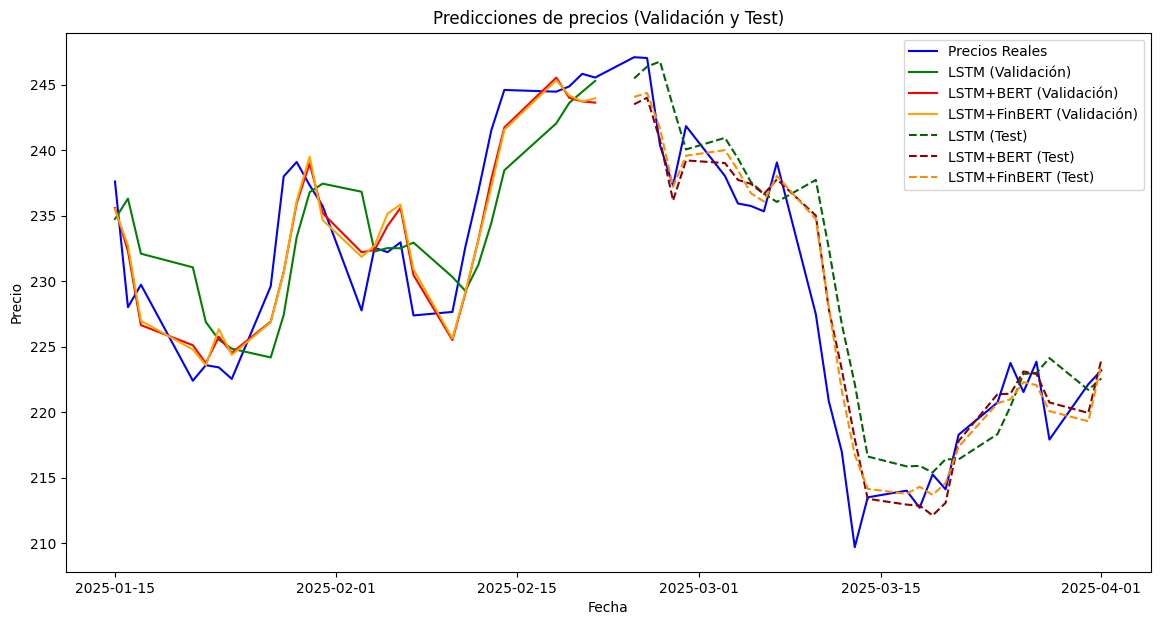

In [12]:
# Guardar modelos
os.makedirs("models", exist_ok=True)
model_price.save("models/model_price.h5")
model_bert. save("models/model_bert.h5")
model_finbert.  save("models/model_finbert.h5")
logging.info("Modelos guardados en 'models/'.")

# Mostrar resultados
datasets = ((X_val_price, y_val_price, X_test_price, y_test_price), (X_val_bert,  y_val_bert,  X_test_bert,  y_test_bert), (X_val_finbert,   y_val_finbert,   X_test_finbert,   y_test_finbert))

models  = (model_price, model_bert, model_finbert)

scalers = ((scaler_price_X, scaler_price_y), (scaler_bert_X, scaler_bert_y), (scaler_finbert_X, scaler_finbert_y))

plot_predictions(models, scalers, datasets, stock_data)

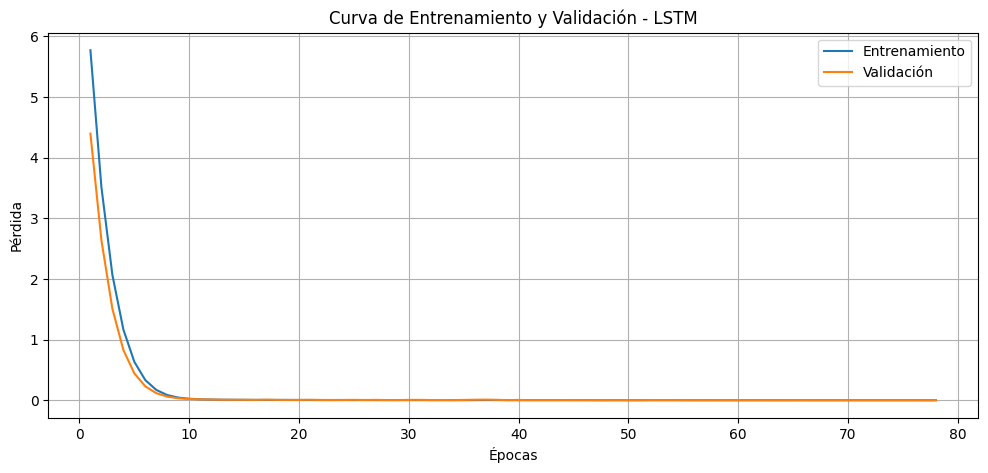

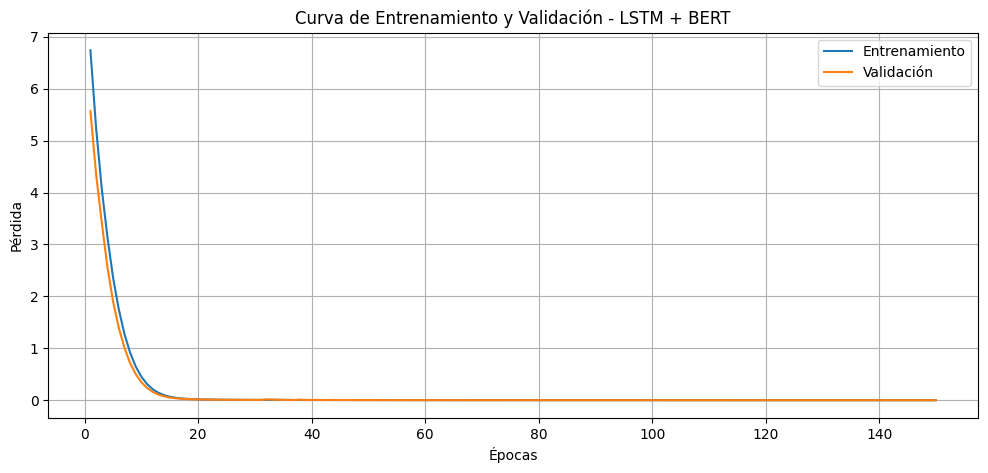

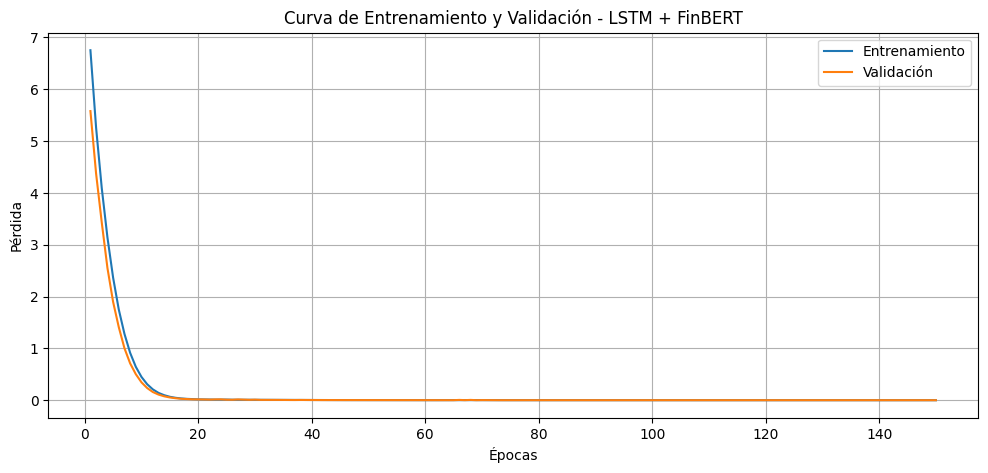

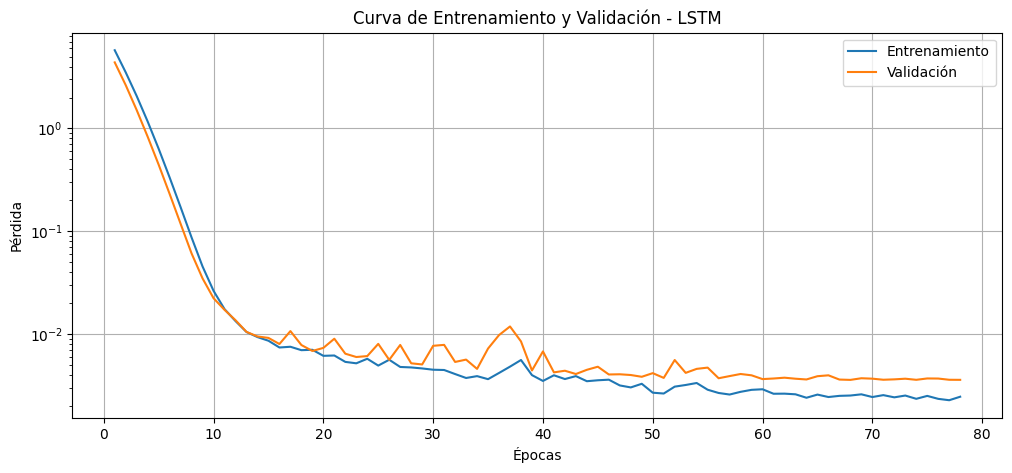

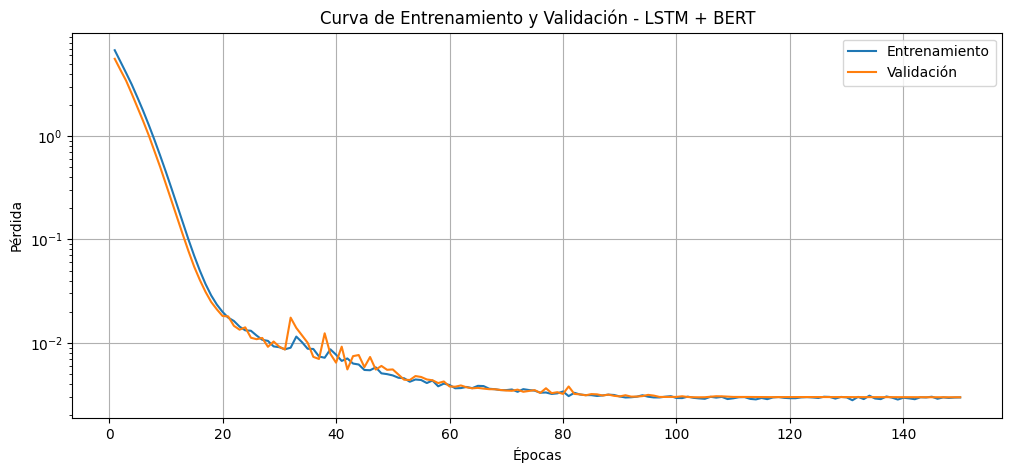

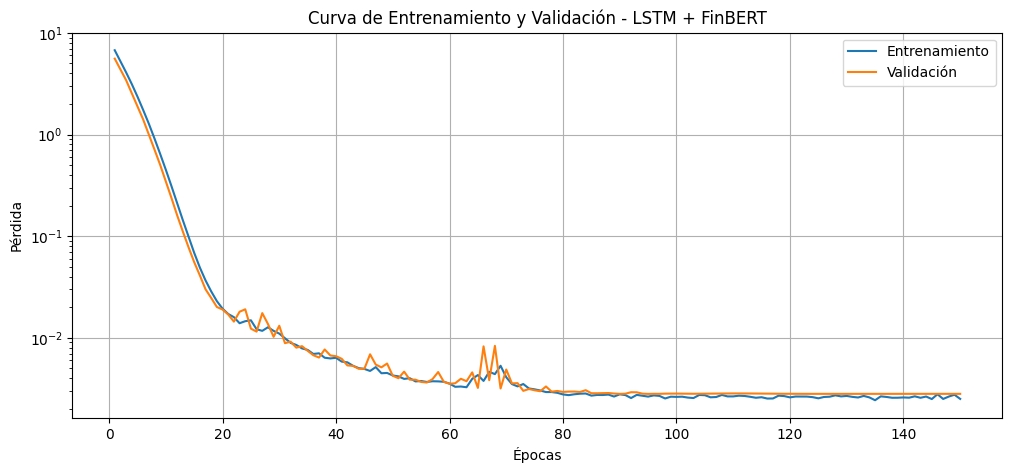

In [13]:
histories = [history_price, history_bert, history_finbert]
names = ['LSTM', 'LSTM + BERT', 'LSTM + FinBERT']

# Gráfico en escala lineal
plot_curves(histories, names, log_scale=False)

# Gráfico en escala logarítmica
plot_curves(histories, names, log_scale=True)

In [14]:
# Primeras filas del DataFrame
print("Primeras filas de stock_data:")
print(stock_data.head())

Primeras filas de stock_data:
         Date        Open        High         Low       Close     Volume  NSI  \
0  2024-03-11  172.127235  173.560470  171.241418  171.938126   60139500    0   
1  2024-03-12  172.336237  173.212106  170.206295  172.415863   59825400   -1   
2  2024-03-13  171.958052  172.376076  169.957488  170.325760   52488700    0   
3  2024-03-14  172.097377  173.490792  171.241418  172.186951   72913500    0   
4  2024-03-15  170.365564  171.808746  169.489695  171.808746  121664700    1   

   Sentiment_BERT  Sentiment_FinBERT  
0       -0.266323          -0.412865  
1       -0.438975           0.000000  
2       -0.214293          -0.029914  
3       -0.614233          -0.035770  
4       -0.435276          -0.221057  


In [15]:
# Resumen estadístico de los datos de precios
print("\nResumen estadístico de los datos de precios:")
print(stock_data.describe())


Resumen estadístico de los datos de precios:
             Open        High         Low       Close        Volume  \
count  266.000000  266.000000  266.000000  266.000000  2.660000e+02   
mean   216.063743  218.323849  214.043174  216.321785  5.561970e+07   
std     24.306496   24.535320   23.981100   24.392036  3.005689e+07   
min    164.572913  165.617978  163.308889  164.224564  2.323470e+07   
25%    205.010971  210.799026  201.722030  206.956947  4.028265e+07   
50%    223.790695  225.533626  221.339702  223.571404  4.849460e+07   
75%    231.700250  233.693061  229.125710  232.419907  6.076482e+07   
max    257.906429  259.814335  257.347047  258.735504  3.186799e+08   

              NSI  Sentiment_BERT  Sentiment_FinBERT  
count  266.000000      266.000000         266.000000  
mean     0.093985       -0.392034          -0.055680  
std      0.733692        0.339322           0.193986  
min     -1.000000       -0.999581          -0.921988  
25%      0.000000       -0.602537      

In [16]:
# Distribución del índice NSI
print("\nDistribución del índice NSI:")
print(stock_data['NSI'].value_counts())


Distribución del índice NSI:
NSI
 0    121
 1     85
-1     60
Name: count, dtype: int64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\bgregori\AppData\Local\Temp\ipykernel_14488\1027228326.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='NSI', data=stock_data, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


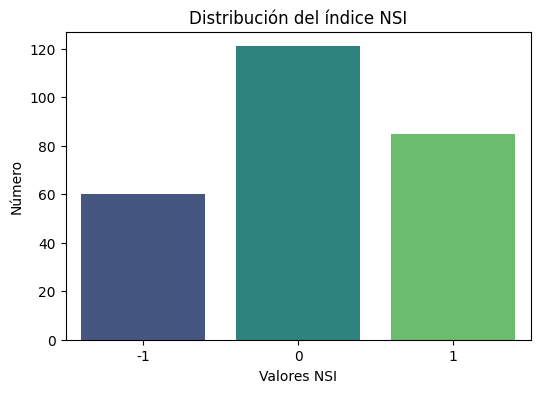

In [17]:
# Visualización de la distribución del índice NSI
plt.figure(figsize=(6,4))
sns.countplot(x='NSI', data=stock_data, palette='viridis')
plt.title("Distribución del índice NSI")
plt.xlabel("Valores NSI")
plt.ylabel("Número")
plt.show()

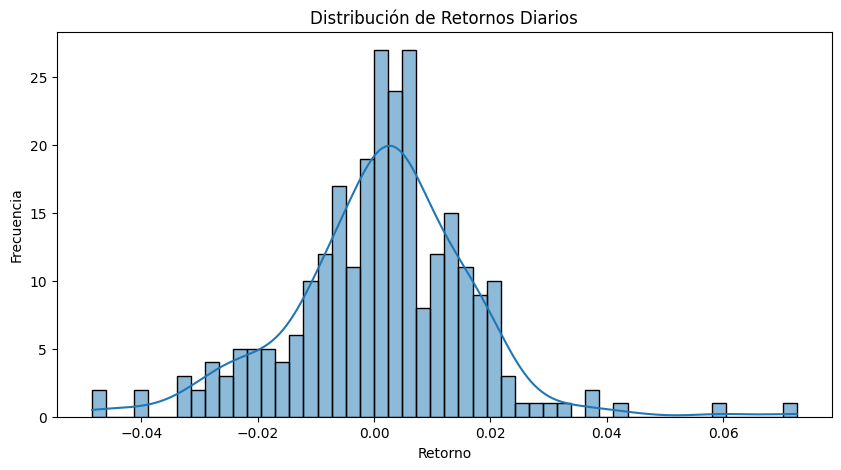

In [18]:
# Calcular retornos porcentuales diarios
stock_data['Return'] = stock_data['Close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(stock_data['Return'].dropna(), kde=True, bins=50)
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno")
plt.ylabel("Frecuencia")
plt.show()

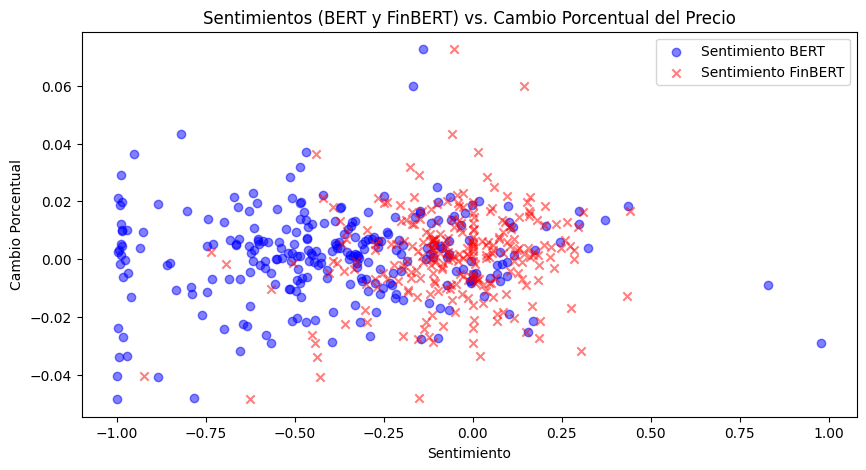

In [19]:
# Gráfico cambio porcentual
plt.figure(figsize=(10,5))
# Declaración BERT
plt.scatter(stock_data['Sentiment_BERT'], stock_data['Close'].pct_change(), alpha=0.5, label='Sentimiento BERT', color='blue')
# Declaración FinBERT
plt.scatter(stock_data['Sentiment_FinBERT'], stock_data['Close'].pct_change(), alpha=0.5, label='Sentimiento FinBERT', color='red', marker='x')

plt.title("Sentimientos (BERT y FinBERT) vs. Cambio Porcentual del Precio")
plt.xlabel("Sentimiento")
plt.ylabel("Cambio Porcentual")
plt.legend()
plt.show()